In [1]:
from google.colab import drive
drive.mount('/content/drive')
! ls /content/drive/My\ Drive/AI\ Cup\ 2020

Mounted at /content/drive
AI_cup_2020_bert_ner.pkl  cna.cbow.cwe_p.tar_g.512d.0.txt  第一階段資料
baseline.ipynb		  data				   第三階段資料
bert_crf_ner_model.pkl	  entity_type_list.txt		   第二階段資料
bert_crf_ner_output.tsv   lecture_baseline		   第五階段資料
bert_ner_baseline.ipynb   ner_output.tsv		   第四階段資料
bert_ner_crf.ipynb	  output.tsv
bert_ner_loss.png	  prediction_4.csv


In [2]:
!pip3 install transformers

     |████████████████████████████████| 1.5MB 23.5MB/s 
     |████████████████████████████████| 2.9MB 56.0MB/s 
     |████████████████████████████████| 890kB 51.5MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=0131708403a2c7f37335f4432512208038e416eadbcac0d8d00463af7d1ee11c
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [4]:
import os
import sys
import numpy as np
import pandas as pd
import time
from tqdm import tqdm, trange
import codecs
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertConfig, BertForTokenClassification, AdamW
from transformers import BertPreTrainedModel, BertModel
from tensorflow.keras.preprocessing.sequence import pad_sequences
import transformers
from transformers import get_linear_schedule_with_warmup
#from seqeval.metrics import f1_score, accuracy_score, precision_score, recall_score, classification_report

#PRETRAINED_MODEL_NAME = "bert-base-chinese"
PRETRAINED_MODEL_NAME = 'bert-base-multilingual-uncased'
#PRETRAINED_MODEL_NAME = 'bert-base-multilingual-cased'

# Download BERT Chinese tokenizer model
tokenizer = BertTokenizer.from_pretrained(PRETRAINED_MODEL_NAME)

print("Transformers version: ", transformers.__version__)
print("PyTorch version: ", torch.__version__)


Transformers version:  4.1.1
PyTorch version:  1.7.0+cu101


## Preprocessing
* Change input data (ex. train.txt) into CRF model input format (ex. train.data)
    * CRF model input format (ex. train.data):
        ```
        肝 O
        功 O
        能 O
        6 B-med_exam
        8 I-med_exam
        ```

In [5]:
file_path='/content/drive/My Drive/AI Cup 2020/data/train_2.txt'

In [6]:
f = open(file_path, 'r', encoding='utf-8')
text = f.read().encode('utf-8').decode('utf-8-sig')
datas=text.split('\n\n--------------------\n\n')[:-1]

In [7]:
trainingset = []
position = []
id = []
start = []
end = []
txt = []
e_type = []
txt_len = []
mentions = {}
for data in datas:
    data=data.split('\n')
    content=data[0]
    trainingset.append(content)
    annotations=data[1:]
    for annot in annotations[1:]:
        annot=annot.split('\t') #annot= article_id, start_pos, end_pos, entity_text, entity_type
        position.extend(annot)
        id.append(int(annot[0]))
        start.append(int(annot[1]))
        end.append(int(annot[2]))
        txt.append(annot[3])
        e_type.append(annot[4])
        txt_len.append(int(annot[2])-int(annot[1]))
        mentions[annot[3]]=annot[4]
        #print(annot[3], '\t', annot[4])
        #print(annot)

In [8]:
label_dic = {}
label_dic['article_id'] = id
label_dic['start_pos'] = start
label_dic['end_pos'] = end
label_dic['entity_text'] = txt
label_dic['entity_type'] = e_type
label_dic['txt_len'] = txt_len

In [9]:
label_df = pd.DataFrame(label_dic)

In [10]:
label_df

article_id  start_pos  end_pos entity_text entity_type  txt_len
0              0         69       71          前天        time        2
1              0         75       77          前天        time        2
2              0        738      740          85    med_exam        2
3              0        741      744         102    med_exam        3
4              0        809      811          前年        time        2
...          ...        ...      ...         ...         ...      ...
3826         199         36       39         1.7    med_exam        3
3827         199         40       43         1.7    med_exam        3
3828         199         48       51         9.0    med_exam        3
3829         199         53       56         1.7    med_exam        3
3830         199       1065     1067          小美        name        2

[3831 rows x 6 columns]

In [11]:
MAX_LEN = 256
#MAX_LEN = max_len
batch_size = 32

In [12]:
data_sen_list = []
data_sen_idx_list = []
article_id_list = []
data_sen_len = []
period_list = []
period_idx = 0
max_len = 0
for j in range(len(trainingset)):
    s = 0
    sen_list = []
    sen_idx_list = []
    id_list = []
    sen_len = []
    for i, c in enumerate(list(trainingset[j])):
        if c == '。':
            period_list.append(i)
            period_idx = period_idx + 1

        if c == '。' and len(trainingset[j][s:period_list[period_idx-1]+1]) > MAX_LEN:
            sen_list.append(trainingset[j][s:period_list[period_idx-2]+1])
            id_list.append(j)
            print(trainingset[j][s:period_list[period_idx-2]+1])
            idx = []
            for k in range(s, period_list[period_idx-2]+1):
                idx.append(k)
            print(idx)
            sen_idx_list.append(idx)
            s = period_list[period_idx-2]+1
            if len(idx) > max_len:
                max_len = len(idx)
            sen_len.append(len(idx))
    data_sen_list.append(sen_list)
    data_sen_idx_list.append(sen_idx_list)
    article_id_list.append(id_list)
    data_sen_len.append(sen_len)
print(max_len)

醫師：啊回去還好嗎？民眾：欸，還是虛虛的，但。醫師：欸，真的。民眾：好險好險。坦白講我剛回去的時候晚上還是有盜汗。醫師：盜汗。民眾：阿只是前天好很多。前天就算沒盜，可是一覺到天明這樣。醫師：一覺到天明齁。我給你看電腦斷層齁。民眾：嘿。還有那個病毒報告不知道出來沒。醫師：病毒齁。民眾：對對對。醫師：它有幫你驗了不少，還有自體免疫呢。民眾：喔。醫師：我相信你之前都驗過。民眾：對阿。醫師：哇，不過你工作壓力很大欸，得潰瘍。民眾：欸，真的阿。醫師：自體免疫，還好。民眾：negative。
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 1

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [13]:
sentences_dic = {}
tmp = []
for id in article_id_list:
    tmp = tmp + id
sentences_dic['article_id'] = tmp
tmp = []
for s in data_sen_list:
    tmp = tmp + s
sentences_dic['sentence'] = tmp
tmp = []
for id in data_sen_idx_list:
    tmp = tmp + id
sentences_dic['sentence_idx_list'] = tmp
tmp = []
for id in data_sen_len:
    tmp = tmp + id
sentences_dic['sent_len'] = tmp

In [14]:
sentences_df = pd.DataFrame(sentences_dic)

In [15]:
sentences_df

article_id  ... sent_len
0              0  ...      242
1              0  ...      251
2              0  ...      252
3              0  ...      246
4              0  ...      234
...          ...  ...      ...
1628         198  ...      221
1629         199  ...      240
1630         199  ...      255
1631         199  ...      219
1632         199  ...      246

[1633 rows x 4 columns]

In [16]:
data_sen_token = []  # All sentences of all aticles
data_sen_token_idx = [] # All sentences' token index of all aticles
data_sen_ner_label = [] # All sentences' NER label of all aticles
for i in range(len(data_sen_list)): # i: article id
    df_tmp = label_df[label_df.article_id == i]
    data_token = [] # All sentences of one article
    data_token_idx = [] # All sentences' token index of one article
    data_ner_label = [] # All sentences' NER label of one article
    for j in range(len(data_sen_list[i])): # j: sentence id in one article
        # Tokenization
        tokens = tokenizer.tokenize(data_sen_list[i][j]) # Tokenize one sentence
        data_token.append(tokens)
        t_idx = [] # Tokenize index list of one sentence
        k = 0
        for t in tokens:
            if t[:2] == '##':
                t = t[2:]
            if t == '[UNK]':
                t_idx.append(data_sen_idx_list[i][j][k:k+1])
                k = k + 1
            else:
                t_idx.append(data_sen_idx_list[i][j][k:k+len(t)])
                k = k + len(t)
        data_token_idx.append(t_idx)
        # NER label
        s_label = [] # NER label of one sentence
        i_type = False
        for w in t_idx:
            if w[0] in list(df_tmp.start_pos):
                df_tmp2 = df_tmp[df_tmp.start_pos == w[0]]
                s_label.append('B-'+list(df_tmp2.entity_type)[0])
                i_type_len = list(df_tmp2.txt_len)[0] - len(w)
                if i_type_len > 0:
                    i_type = True
            elif i_type:
                s_label.append('I-'+list(df_tmp2.entity_type)[0])
                i_type_len = i_type_len - len(w)
                if i_type_len == 0:
                    i_type = False
            else:
                s_label.append('O')
        data_ner_label.append(s_label)
    data_sen_token.append(data_token)
    data_sen_token_idx.append(data_token_idx)
    data_sen_ner_label.append(data_ner_label)

In [17]:
tmp = []
for lst in data_sen_token:
    tmp = tmp + lst
sentences_dic['sentence_token'] = tmp
tmp = []
for lst in data_sen_token_idx:
    tmp = tmp + lst
sentences_dic['token_idx_list'] = tmp
tmp = []
for lst in data_sen_ner_label:
    tmp = tmp + lst
sentences_dic['ner_label'] = tmp

sentences_df = pd.DataFrame(sentences_dic)

In [18]:
entity_type_list = []
for t in set(list(label_df.entity_type)):
    entity_type_list.extend(['B-'+t, 'I-'+t])
entity_type_list.extend(['O', 'PAD'])
print(entity_type_list)

['B-organization', 'I-organization', 'B-med_exam', 'I-med_exam', 'B-location', 'I-location', 'B-education', 'I-education', 'B-name', 'I-name', 'B-family', 'I-family', 'B-contact', 'I-contact', 'B-clinical_event', 'I-clinical_event', 'B-money', 'I-money', 'B-others', 'I-others', 'B-ID', 'I-ID', 'B-profession', 'I-profession', 'B-time', 'I-time', 'O', 'PAD']


In [19]:
num_labels = len(entity_type_list)

In [20]:
with open('/content/drive/My Drive/AI Cup 2020/entity_type_list.txt', 'w') as f:
    for item in entity_type_list:
        f.write("%s\n" % item)

In [21]:
tag_index = {t: i for i, t in enumerate(entity_type_list)}
index_tag = {i: t for i, t in enumerate(entity_type_list)}

In [22]:
print(tag_index)

{'B-organization': 0, 'I-organization': 1, 'B-med_exam': 2, 'I-med_exam': 3, 'B-location': 4, 'I-location': 5, 'B-education': 6, 'I-education': 7, 'B-name': 8, 'I-name': 9, 'B-family': 10, 'I-family': 11, 'B-contact': 12, 'I-contact': 13, 'B-clinical_event': 14, 'I-clinical_event': 15, 'B-money': 16, 'I-money': 17, 'B-others': 18, 'I-others': 19, 'B-ID': 20, 'I-ID': 21, 'B-profession': 22, 'I-profession': 23, 'B-time': 24, 'I-time': 25, 'O': 26, 'PAD': 27}


In [23]:
print(index_tag)

{0: 'B-organization', 1: 'I-organization', 2: 'B-med_exam', 3: 'I-med_exam', 4: 'B-location', 5: 'I-location', 6: 'B-education', 7: 'I-education', 8: 'B-name', 9: 'I-name', 10: 'B-family', 11: 'I-family', 12: 'B-contact', 13: 'I-contact', 14: 'B-clinical_event', 15: 'I-clinical_event', 16: 'B-money', 17: 'I-money', 18: 'B-others', 19: 'I-others', 20: 'B-ID', 21: 'I-ID', 22: 'B-profession', 23: 'I-profession', 24: 'B-time', 25: 'I-time', 26: 'O', 27: 'PAD'}


In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
!nvidia-smi

cuda
Mon Dec 28 03:26:19 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8     9W /  70W |     10MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+--

In [25]:
all_tokenized_texts = list(sentences_df.sentence_token)
all_labels = list(sentences_df.ner_label)

In [26]:
test_size = int(len(all_tokenized_texts) * 0.2)
#test_size = int(len(all_labels) * 0.2)
test_size

326

In [27]:
val_tokenized_texts = all_tokenized_texts[-test_size:]
val_labels = all_labels[-test_size:]
#len(val_tokenized_texts)
len(val_labels)

326

In [28]:
train_tokenized_texts = all_tokenized_texts[:-test_size]
train_labels = all_labels[:-test_size]
len(train_labels)

1307

In [29]:
train_input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in train_tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")

In [30]:
train_tags = pad_sequences([[tag_index.get(l) for l in lab] for lab in train_labels],
                     maxlen=MAX_LEN, value=tag_index["PAD"], padding="post",
                     dtype="long", truncating="post")

Generate masks for every input sequence to mask the inserted PAD(0) tokens.

In [31]:
train_attention_masks = [[float(i != 0.0) for i in id] for id in train_input_ids]
print(train_attention_masks[5])

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,

In [32]:
val_input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in val_tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")
val_tags = pad_sequences([[tag_index.get(l) for l in lab] for lab in val_labels],
                     maxlen=MAX_LEN, value=tag_index["PAD"], padding="post",
                     dtype="long", truncating="post")

In [33]:
val_attention_masks = [[float(i != 0.0) for i in ii] for ii in val_input_ids]
#print(val_attention_masks[2])

Convert arrays into tensors

In [34]:
train_inputs = torch.tensor(train_input_ids)
val_inputs = torch.tensor(val_input_ids)
train_tags = torch.tensor(train_tags)
val_tags = torch.tensor(val_tags)
train_masks = torch.tensor(train_attention_masks)
val_masks = torch.tensor(val_attention_masks)

Generate data loaders according to the batch size and use random sampler for training dataset and sequential sampler for validation dataset.

In [35]:
training_data = TensorDataset(train_inputs, train_masks, train_tags)
training_sampler = RandomSampler(training_data)
training_dataloader = DataLoader(training_data, sampler=training_sampler, batch_size=batch_size)

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=batch_size)

Load the pretrained multi-lingual BERT model for token classification from PyTorch Hub.

In [36]:
ner_model = BertForTokenClassification.from_pretrained(
    #"bert-base-multilingual-cased",
    PRETRAINED_MODEL_NAME,
    num_labels=len(tag_index),
    output_attentions = False,
    output_hidden_states = False
)

Some weights of the model checkpoint at bert-base-multilingual-uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint a

In [37]:
%%time
ner_model.cuda();

CPU times: user 3.53 s, sys: 1.7 s, total: 5.22 s
Wall time: 14.4 s


BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(105879, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwi

Set to full finetune the pretrained bert model and choose the AdamW optimizer.

In [38]:
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(ner_model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(ner_model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=3e-5,
    eps=1e-8
)

Set hyperparameters

In [39]:
epochs = 10
max_grad_norm = 1.0

# Total number of training steps is number of batches * number of epochs.
total_steps = len(training_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

### Training loop and validation loop

In [40]:
tick1 = time.time()
localtime = time.asctime(time.localtime(time.time()))
print("開始時間是：", localtime)
#------------------------------------------------------------------------------#

loss_values, validation_loss_values = [], []

for _ in trange(epochs, desc="Epoch"):
    # ========================================
    #               Training
    # ========================================

    # Set the ner model to training mode.
    ner_model.train()
    total_loss = 0

    # Training loop
    for step, batch in enumerate(training_dataloader):
        # add batch to device (gpu or cpu)
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # reset gradients before performing a backward pass.
        ner_model.zero_grad()
        # forward pass, get the training loss
        outputs = ner_model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask, labels=b_labels)
        # get the training loss
        loss = outputs[0]
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        total_loss += loss.item()
        # Clip the norm of the gradient to prevent from the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(parameters=ner_model.parameters(), max_norm=max_grad_norm)
        # update parameters
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(training_dataloader)
    print("Average train loss: {}".format(avg_train_loss))

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)


    # ========================================
    #               Validation
    # ========================================

    # Set the ner model to evaluation mode
    ner_model.eval()
    # Reset the validation loss
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        # Don't need to compute gradients
        with torch.no_grad():
            # Forward pass, calculate the predicted logits
            outputs = ner_model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask, labels=b_labels)
        # Move logits and labels to CPU
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
        eval_loss += outputs[0].mean().item()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)

    eval_loss = eval_loss / len(valid_dataloader)
    validation_loss_values.append(eval_loss)
    print("Validation loss: {}".format(eval_loss))
    
    #pred_tags = []
    #valid_tags = []
    #for p, l in zip(predictions, true_labels):
    #    preds = []
    #    labs = []
    #    for p_i, l_i in zip(p, l):
    #        if index_tag[l_i] != "PAD":
    #            preds.append(index_tag[p_i])
    #            labs.append(index_tag[l_i])
    #    pred_tags.append(preds)
    #    valid_tags.append(labs)
    
    #print("Validation Precision: {}".format(precision_score(valid_tags, pred_tags)))
    #print("Validation Recall: {}".format(recall_score(valid_tags, pred_tags)))
    #print("Validation Accuracy: {}".format(accuracy_score(valid_tags, pred_tags)))
    #print("Validation F1-Score: {}".format(f1_score(valid_tags, pred_tags)))
    #print("Report: {}".format(classification_report(valid_tags, pred_tags)))
    #print()
    if eval_loss < 0.045:
        ner_model.train()
        torch.save(ner_model, '/content/drive/My Drive/AI Cup 2020/AI_cup_2020_bert_ner.pkl')

#------------------------------------------------------------------------------#
localtime = time.asctime(time.localtime(time.time()))
print("結束時間是：", localtime)

tick2 = time.time()
print("Elapsed time: ", tick2 - tick1)
print(time.strftime("%H:%M:%S", time.localtime(tick2-tick1-3600*8)))

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

開始時間是： Mon Dec 28 03:26:56 2020
Average train loss: 0.31871948445715553


Epoch:  10%|█         | 1/10 [01:01<09:16, 61.84s/it]

Validation loss: 0.09153997153043747
Average train loss: 0.0802116804733509


Epoch:  20%|██        | 2/10 [02:09<08:29, 63.73s/it]

Validation loss: 0.067547968165441
Average train loss: 0.055034644810891736


Epoch:  30%|███       | 3/10 [03:22<07:44, 66.40s/it]

Validation loss: 0.05386261777444319
Average train loss: 0.03906158866678796
Validation loss: 0.047194053334268654


Epoch:  40%|████      | 4/10 [04:43<07:03, 70.60s/it]

Average train loss: 0.03115468872029607
Validation loss: 0.04474613316018473


Epoch:  50%|█████     | 5/10 [05:59<06:01, 72.32s/it]

Average train loss: 0.025901059756373485


Epoch:  60%|██████    | 6/10 [07:11<04:49, 72.39s/it]

Validation loss: 0.049115803177383816


KeyboardInterrupt: ignored

### Save the model

In [ ]:
#ner_model.train()
#torch.save(ner_model, '/content/drive/My Drive/AI Cup 2020/AI_cup_2020_bert_ner.pkl')

### Load the model

In [41]:
ner_model = torch.load('/content/drive/My Drive/AI Cup 2020/AI_cup_2020_bert_ner.pkl')
ner_model.eval()

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(105879, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwi

### Load Tag Dictionary

In [42]:
with open('/content/drive/My Drive/AI Cup 2020/entity_type_list.txt', 'r') as f:
    entity_list = f.read().splitlines()
tag_index = {t: i for i, t in enumerate(entity_list)}
index_tag = {i: t for i, t in enumerate(entity_list)}

#### Plot the learning curve of the model

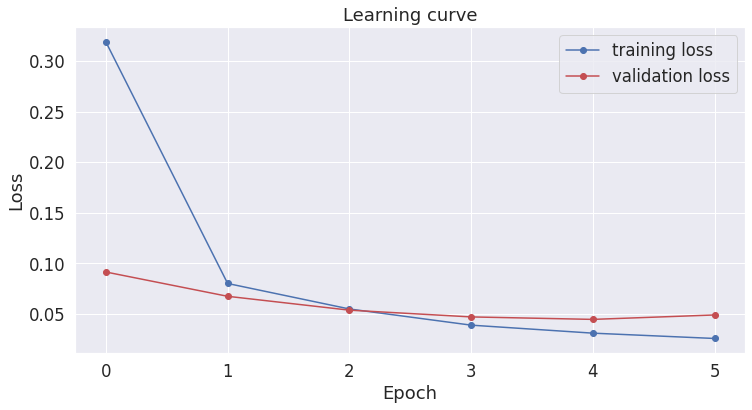

<Figure size 864x432 with 0 Axes>

In [43]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o', label="training loss")
plt.plot(validation_loss_values, 'r-o', label="validation loss")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()
plt.savefig('/content/drive/My Drive/AI Cup 2020/bert_ner_loss.png')

Use the trained BERT NER model to infer the named entities of the test sentence.

### Test

In [44]:
test_file_path='/content/drive/My Drive/AI Cup 2020/data/test.txt'

In [45]:
f = open(test_file_path, 'r', encoding='utf-8')
text = f.read().encode('utf-8').decode('utf-8-sig')
datas=text.split('\n\n--------------------\n\n')[:-1]

In [46]:

testset = []
test_id = []
for data in datas:
    data=data.split('\n')
    content=data[1]
    testset.append(content)
    test_id.append(int(data[0][12:]))


In [47]:
test_data_sen_list = []
test_data_sen_idx_list = []
test_article_id_list = []
test_data_sen_len = []
test_period_list = []
test_period_idx = 0
test_max_len = 0
for j in range(len(testset)):
    s = 0
    sen_list = []
    sen_idx_list = []
    id_list = []
    sen_len = []
    for i, c in enumerate(list(testset[j])):
        if c == '。':
            test_period_list.append(i)
            test_period_idx = test_period_idx + 1

        if c == '。' and len(testset[j][s:test_period_list[test_period_idx-1]+1]) > MAX_LEN:
            sen_list.append(testset[j][s:test_period_list[test_period_idx-2]+1])
            id_list.append(j)
            print(testset[j][s:test_period_list[test_period_idx-2]+1])
            idx = []
            for k in range(s, test_period_list[test_period_idx-2]+1):
                idx.append(k)
            print(idx)
            sen_idx_list.append(idx)
            s = test_period_list[test_period_idx-2]+1
            if len(idx) > test_max_len:
                test_max_len = len(idx)
            sen_len.append(len(idx))
    test_data_sen_list.append(sen_list)
    test_data_sen_idx_list.append(sen_idx_list)
    test_article_id_list.append(id_list)
    test_data_sen_len.append(sen_len)
print(test_max_len)

醫師：最近人有沒有什麼不舒服？民眾：沒有。醫師：沒有喔。我們本來說要月，年底才打對不對？民眾：對，但……醫師：你是怕？民眾：因為我要治療牙，開始要治療牙齒了。醫師：喔。民眾：啊我又不常跑醫院。醫師：喔。民眾：我想說那先來打，我今天來領藥嘛，那順便過來打。醫師：喔，是是是。啊你是要做？民眾：植牙。醫師：植牙的。民眾：對對對。醫師：喔。啊你的免疫力是夠，是沒有問題的。在我們這裡做的嗎？民眾：對，在新樓做的。醫師：诶？那這樣離你住的地方也有點距離欸，你是住麻豆嗎？民眾：對，住麻豆。
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173

In [48]:

test_sentences_dic = {}
tmp = []
for id in test_article_id_list:
    tmp = tmp + id
test_sentences_dic['article_id'] = tmp
tmp = []
for s in test_data_sen_list:
    tmp = tmp + s
test_sentences_dic['sentence'] = tmp
tmp = []
for id in test_data_sen_idx_list:
    tmp = tmp + id
test_sentences_dic['sentence_idx_list'] = tmp


In [49]:
test_sentences_df = pd.DataFrame(test_sentences_dic)

In [50]:
Total_sent = len(test_sentences_df)

In [51]:
test_sentences_df

article_id  ...                                  sentence_idx_list
0              0  ...  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
1              0  ...  [240, 241, 242, 243, 244, 245, 246, 247, 248, ...
2              1  ...  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
3              1  ...  [250, 251, 252, 253, 254, 255, 256, 257, 258, ...
4              1  ...  [493, 494, 495, 496, 497, 498, 499, 500, 501, ...
...          ...  ...                                                ...
1043         158  ...  [253, 254, 255, 256, 257, 258, 259, 260, 261, ...
1044         158  ...  [494, 495, 496, 497, 498, 499, 500, 501, 502, ...
1045         158  ...  [749, 750, 751, 752, 753, 754, 755, 756, 757, ...
1046         158  ...  [975, 976, 977, 978, 979, 980, 981, 982, 983, ...
1047         158  ...  [1219, 1220, 1221, 1222, 1223, 1224, 1225, 122...

[1048 rows x 3 columns]

In [52]:

test_data_sen_token = []  # All sentences of all aticles
test_data_sen_token_idx = [] # All sentences' token index of all aticles
test_data_sen_len = []
for i in range(len(test_data_sen_list)): # i: article id
    test_data_token = [] # All sentences of one article
    test_data_token_idx = [] # All sentences' token index of one article
    token_len = [] # Token length of every sentence
    for j in range(len(test_data_sen_list[i])): # j: sentence id in one article
        # Tokenization
        tokens = tokenizer.tokenize(test_data_sen_list[i][j]) # Tokenize one sentence
        test_data_token.append(tokens)
        t_idx = [] # Tokenize index list of one sentence
        k = 0
        for t in tokens:
            if t[:2] == '##':
                t = t[2:]
            if t == '[UNK]':
                t_idx.append(test_data_sen_idx_list[i][j][k:k+1])
                k = k + 1
            else:
                t_idx.append(test_data_sen_idx_list[i][j][k:k+len(t)])
                k = k + len(t)
        test_data_token_idx.append(t_idx)
        token_len.append(len(tokens))
    test_data_sen_token.append(test_data_token)
    test_data_sen_token_idx.append(test_data_token_idx)
    test_data_sen_len.append(token_len)


In [53]:

tmp = []
for lst in test_data_sen_token:
    tmp = tmp + lst
test_sentences_dic['sentence_token'] = tmp
tmp = []
for lst in test_data_sen_token_idx:
    tmp = tmp + lst
test_sentences_dic['token_idx_list'] = tmp
tmp = []
for lst in test_data_sen_len:
    tmp = tmp + lst
test_sentences_dic['sent_len'] = tmp

test_sentences_df = pd.DataFrame(test_sentences_dic)


In [54]:
test_tokenized_texts = list(test_sentences_df.sentence_token)

In [55]:

test_input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in test_tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")


In [56]:
test_attention_masks = [[float(i != 0.0) for i in id] for id in test_input_ids]
#print(test_attention_masks[0])

In [57]:
test_inputs = torch.tensor(test_input_ids)
test_masks = torch.tensor(test_attention_masks)

In [58]:
test_data = TensorDataset(test_inputs, test_masks)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

### Test Loop

In [59]:
%%time

test_pred_tags, test_predictions = [], []
for batch in test_dataloader:
#for batch in training_dataloader:
    batch = tuple(t.to(device) for t in batch)
    #b_input_ids, b_input_mask, b_labels = batch
    b_input_ids, b_input_mask = batch

    with torch.no_grad():
        # Forward pass, calculate the predicted logits
        outputs = ner_model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask)
    # Move logits to CPU
    logits = outputs[0].detach().cpu().numpy()    
    test_predictions.extend([list(p) for p in np.argmax(logits, axis=2)])

CPU times: user 10.1 s, sys: 7.47 s, total: 17.6 s
Wall time: 17.6 s


In [61]:
test_pred_tags = []
for i in range(Total_sent):
    pred = []
    for p in test_predictions[i][:test_sentences_df.sent_len[i]]:
        pred.append(index_tag[p])
    test_pred_tags.append(pred)
    print(pred)

['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-locati

In [62]:
article_id = []
start_pos = []
end_position = []
entity_text = []
entity_type = []
txt_tokens = ''
entity_found = False
for i in range(Total_sent):
    for j in range(len(test_pred_tags[i])):
        if test_pred_tags[i][j-1][0] == 'O' and test_pred_tags[i][j][0] == 'B':
            entity_found = True
            article_id.append(test_sentences_df.article_id[i])
            start_pos.append(test_sentences_df.token_idx_list[i][j][0])
            if test_sentences_df.sentence_token[i][j][:2] == '##':
                txt_tokens = test_sentences_df.sentence_token[i][j][2:]
            else:
                txt_tokens = test_sentences_df.sentence_token[i][j]
            entity_type.append(test_pred_tags[i][j][2:])
        elif test_pred_tags[i][j-1][0] == 'B' and test_pred_tags[i][j][0] == 'B':
            if test_sentences_df.sentence_token[i][j][:2] == '##':
                txt_tokens = txt_tokens + test_sentences_df.sentence_token[i][j][2:]
            else:
                txt_tokens = txt_tokens + test_sentences_df.sentence_token[i][j]
        elif test_pred_tags[i][j-1][0] == 'B' and test_pred_tags[i][j][0] == 'I':
            if test_sentences_df.sentence_token[i][j][:2] == '##':
                txt_tokens = txt_tokens + test_sentences_df.sentence_token[i][j][2:]
            else:
                txt_tokens = txt_tokens + test_sentences_df.sentence_token[i][j]
        elif test_pred_tags[i][j-1][0] == 'I' and test_pred_tags[i][j][0] == 'I':
            if entity_found == True:
                if test_sentences_df.sentence_token[i][j][:2] == '##':
                    txt_tokens = txt_tokens + test_sentences_df.sentence_token[i][j][2:]
                else:
                    txt_tokens = txt_tokens + test_sentences_df.sentence_token[i][j]
        elif (test_pred_tags[i][j-1][0] == 'B' or test_pred_tags[i][j-1][0] == 'I') and test_pred_tags[i][j][0] == 'O':
            if entity_found == True:
                entity_text.append(txt_tokens)
                txt_tokens = ''
                end_position.append(test_sentences_df.token_idx_list[i][j][0])
                entity_found = False

In [63]:
ner_output = {}
ner_output['article_id'] = article_id
ner_output['start_position'] = start_pos
ner_output['end_position'] = end_position
ner_output['entity_text'] = entity_text
ner_output['entity_type'] = entity_type

In [64]:
ner_output_df = pd.DataFrame(ner_output)

In [65]:
ner_output_df

article_id  start_position  end_position entity_text entity_type
0              0             198           200          新樓    location
1              0             295           296           今        time
2              1              40            41           昨        time
3              1              76            80          0.    med_exam
4              1              94            96          88    med_exam
...          ...             ...           ...         ...         ...
2372         157            3619          3621          四週        time
2373         158              91            94         這個月        time
2374         158             127           130         這個月        time
2375         158             193           197        四個禮拜        time
2376         158            1380          1390  a124699678    med_exam

[2377 rows x 5 columns]

In [66]:
ner_output_df.to_csv("/content/drive/My Drive/AI Cup 2020/ner_output.tsv", sep="\t", index=False, encoding='utf-8-sig')

## Output data
* Change model output into `output.tsv` 
* Only accept this output format uploading to competition system